In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import datetime
import random
import os
import re
from collections import defaultdict
from scipy.stats import chi2_contingency, pointbiserialr

In [2]:
#!pip freeze

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
sns.set(rc={'figure.figsize':(15,10)})

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)  
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

## 1. Importing data

In [5]:
def import_csv(filename, path = './data'):
    return pd.read_csv(os.path.join(path, filename))

In [6]:
test_activity = import_csv('act_test.csv')
train_activity = import_csv('act_train.csv')
people = import_csv('people.csv')

In [7]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [8]:
train_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [9]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,type 2,type 2,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,type 2,type 2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,84


- Each row in the activity file represents a **unique activity** performed by a person on a certain date. Each activity has a unique activity_id.
- The activity file contains several different categories of activities. 
- **Type 1** activities are different from type 2-7 activities because there are more known chars associated with type 1 activities (**nine in total**) than type 2-7 activities (which have only one associated characteristic).
- The two files can be joined together using **person_id** as the common key. 
- All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

## 2. Data cleaning

In [10]:
def _process_date(dataframe, date_col):
    """
    A private function which preprocesses datetime information.
    Input:
    - dataframe
    - name of the date column (object)
    
    Output:
    - dataframe with new date columns: month, year, weekend_flg
    """
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df[date_col])
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['weekend_flg'] = (df['date'].dt.weekday >= 5).astype(int)
    df.drop(['date'], inplace=True, axis=1)
    return df

### 2.1. `People` dataframe

In [11]:
def clean_people(original_df):
    """
    The aim of this function is to prepare `people` df by unifying types of data.
    The function takes in a dataframe (specifically `people`) and returns a copy of the given dataframe, but with converted data types (all ints).
    """
    df = _process_date(original_df, 'date')
    
    for col in list(df.select_dtypes(include='object').columns):
        if col.startswith("char_") or col.startswith("group_"):
            try:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted to int")
            except AttributeError:
                print(f"Can't convert {col} to int")

        elif col.startswith("people_"):
            try:
                df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype('int64')
                print(f'{col} converted to int')
            except AttributeError:
                print(f"Can't convert {col} to int")
                
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
            print(f"Can't convert {col} to int")
    return df

In [12]:
people_df = clean_people(people)

people_id converted to int
char_1 converted to int
group_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int
char_11 converted to int
char_12 converted to int
char_13 converted to int
char_14 converted to int
char_15 converted to int
char_16 converted to int
char_17 converted to int
char_18 converted to int
char_19 converted to int
char_20 converted to int
char_21 converted to int
char_22 converted to int
char_23 converted to int
char_24 converted to int
char_25 converted to int
char_26 converted to int
char_27 converted to int
char_28 converted to int
char_29 converted to int
char_30 converted to int
char_31 converted to int
char_32 converted to int
char_33 converted to int
char_34 converted to int
char_35 converted to int
char_36 converted to int
char_37 converted to int


In [13]:
del people

In [14]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


### 2.2. `Activity` dataframes

In [15]:
for data in [test_activity,train_activity]:
    print(data.isnull().sum())
    print("\n")

people_id                 0
activity_id               0
date                      0
activity_category         0
char_1               458595
char_2               458595
char_3               458595
char_4               458595
char_5               458595
char_6               458595
char_7               458595
char_8               458595
char_9               458595
char_10               40092
dtype: int64


people_id                  0
activity_id                0
date                       0
activity_category          0
char_1               2039676
char_2               2039676
char_3               2039676
char_4               2039676
char_5               2039676
char_6               2039676
char_7               2039676
char_8               2039676
char_9               2039676
char_10               157615
outcome                    0
dtype: int64




In [16]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [17]:
#probably should extract this too with the rest of the activity id
train_activity['activity_id'].apply(lambda x: x.split("_")[0][-1]).unique()

array(['2', '1'], dtype=object)

In [18]:
def clean_activity(original_df):
    """
    The aim of this function is to prepare `activity` df (and test df) by unifying types of data.
    The function takes in a dataframe (specifically `activity`) and returns this dataframe, but with converted data types.
    """ 

    df = _process_date(original_df, 'date')
                               
    for col in list(df.select_dtypes(include='object').columns):
        if col.endswith("_id"):
            if col.startswith("activity"):
                try:
                    df[f"{col}_prefix"] = (df[col].apply(lambda x: x.split("_")[0][-1]).astype("float64")).astype("int64")
                    print(f"{col}_prefix created")
                except AttributeError:
                    print(f"Can't create {col}_prefix")
                try:
                    df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype("int64")
                    print(f"{col} converted to int")
                except AttributeError:
                    print(f"Can't convert {col} to int")              
            elif col.startswith("people"):
                try:
                    df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype("int64")
                    print(f"{col} converted to int")
                except AttributeError:
                    print(f"Can't convert {col} to int")
        else:
            df[col]= df[col].fillna('type -1')
            try:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted to int")
            except AttributeError:
                print(f"Can't convert {col} to int")
                
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
            print(f"Can't convert {col} to int")
    return df

In [19]:
train_activity_df= clean_activity(train_activity)

people_id converted to int
activity_id_prefix created
activity_id converted to int
activity_category converted to int
char_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int


In [20]:
train_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,month,year,weekend_flg,activity_id_prefix
0,100,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2
1,100,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2
2,100,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2
3,100,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2
4,100,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2


In [21]:
test_activity_df= clean_activity(test_activity)

people_id converted to int
activity_id_prefix created
activity_id converted to int
activity_category converted to int
char_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int


In [22]:
test_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,month,year,weekend_flg,activity_id_prefix
0,100004,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0,1
1,100004,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0,2
2,10001,240724,1,12,1,5,4,6,1,1,13,10,-1,10,2022,0,1
3,10001,83552,1,20,10,5,4,6,1,1,5,5,-1,11,2022,1,1
4,10001,1043301,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3015,10,2022,1,2


In [23]:
del train_activity
del test_activity

### 2.3. Creating a complete activity variable

In [24]:
def extract_activity(df, index=True):
    df['activity_index'] = df[['activity_id_prefix', 'activity_id']].apply(tuple, axis=1)
    if index:
        return df.set_index('activity_index')
    return df

In [25]:
test_activity_df = extract_activity(test_activity_df, False)
train_activity_df = extract_activity(train_activity_df, False)

In [26]:
test_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,month,year,weekend_flg,activity_id_prefix,activity_index
0,100004,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0,1,"(1, 249281)"
1,100004,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0,2,"(2, 230855)"
2,10001,240724,1,12,1,5,4,6,1,1,13,10,-1,10,2022,0,1,"(1, 240724)"
3,10001,83552,1,20,10,5,4,6,1,1,5,5,-1,11,2022,1,1,"(1, 83552)"
4,10001,1043301,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3015,10,2022,1,2,"(2, 1043301)"


In [27]:
train_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,month,year,weekend_flg,activity_id_prefix,activity_index
0,100,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2,"(2, 1734928)"
1,100,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 2434093)"
2,100,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 3404049)"
3,100,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2,"(2, 3651215)"
4,100,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2,"(2, 4109017)"


## 3. Data exploration

### 3.1. Exploring `train_activity_df`

In [28]:
list(train_activity_df.columns)

['people_id',
 'activity_id',
 'activity_category',
 'char_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'outcome',
 'month',
 'year',
 'weekend_flg',
 'activity_id_prefix',
 'activity_index']

#### 3.1.1. Chars

In [29]:
chars = list(train_activity_df.filter(regex= 'char_', axis=1).columns)

In [30]:
chars_acts_unique=defaultdict(int)

In [31]:
for char in chars:
    chars_acts_unique[char]= len((list(train_activity_df[char].unique())))

In [32]:
#type 10 stands out significantly
chars_acts_unique

defaultdict(int,
            {'char_1': 52,
             'char_2': 33,
             'char_3': 12,
             'char_4': 8,
             'char_5': 8,
             'char_6': 6,
             'char_7': 9,
             'char_8': 19,
             'char_9': 20,
             'char_10': 6516})

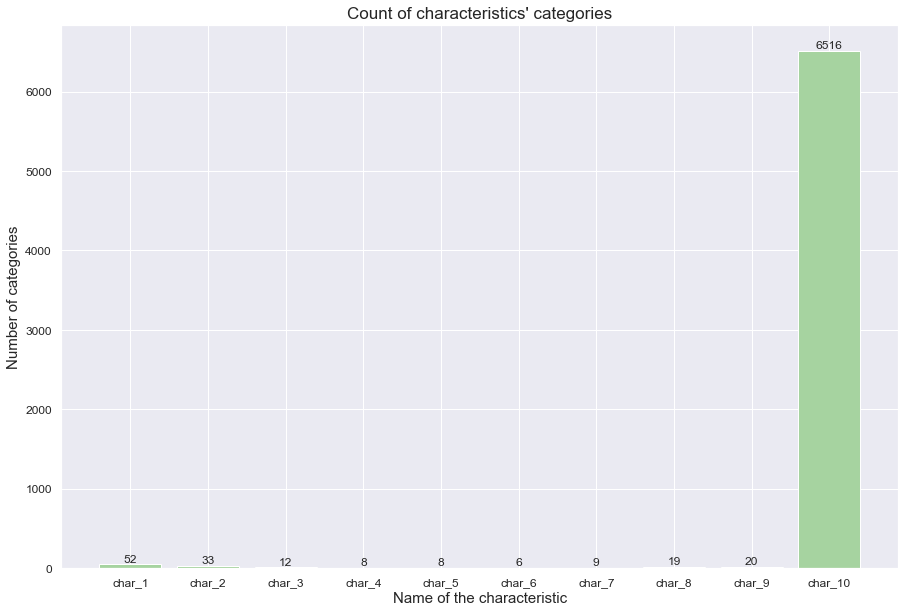

In [33]:
b = plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center', color = '#A6D3A0')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

`Char_10` differs significantly from the other characteristics - it contains more than 6000 categories

In [34]:
chars_acts_unique.pop('char_10')

6516

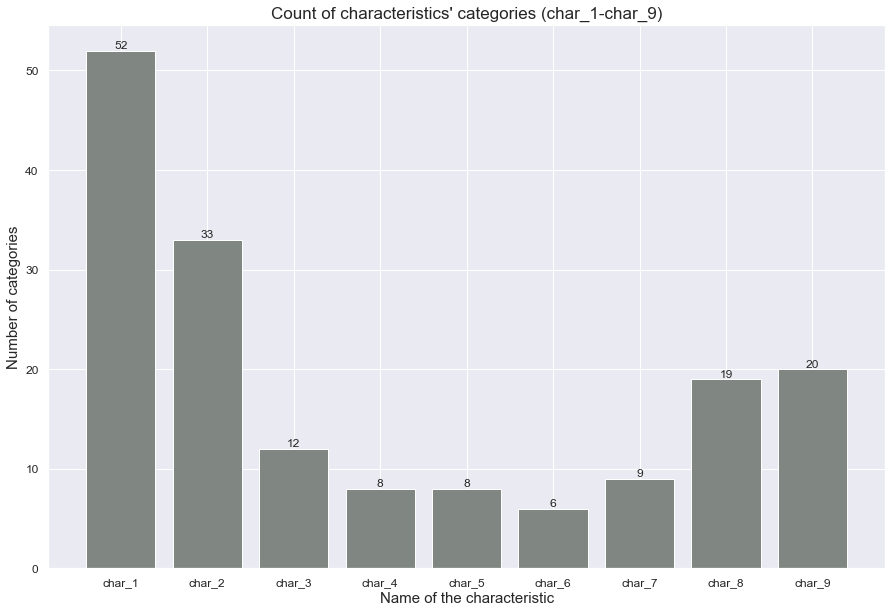

In [35]:
b = plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center', color = '#808782')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories (char_1-char_9)")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

**`char_10`**

In [36]:
char10_stats = (pd.DataFrame(train_activity_df['char_10'].value_counts().sort_values(ascending=False)).reset_index()).rename(columns={'index':'type','char_10':'count'})

Text(0.5, 1.0, 'Distribution of values of char_10')

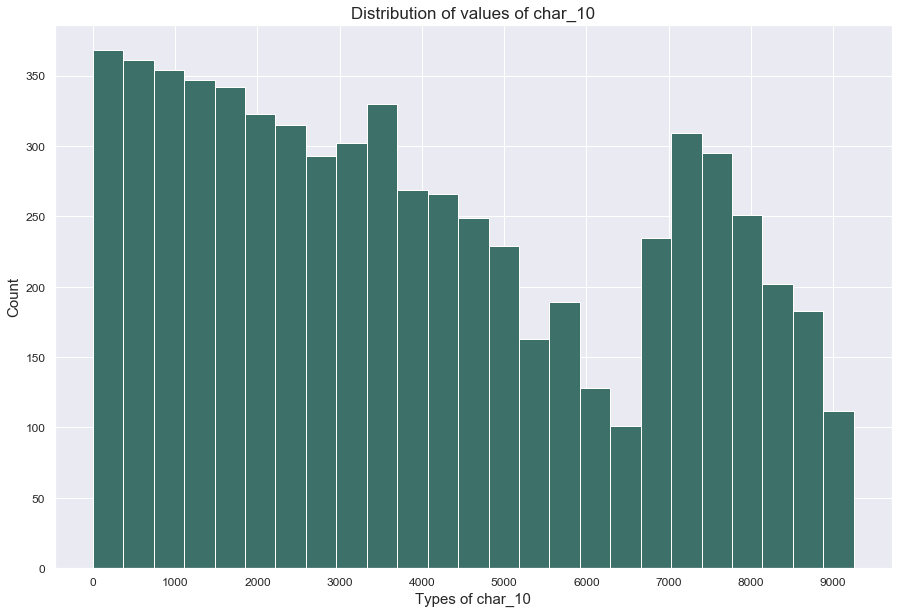

In [37]:
plt.hist(char10_stats['type'], bins=25, color = '#3D7068')
plt.xlabel('Types of char_10')
plt.ylabel('Count')
plt.xticks(ticks=list(range(0,9500,1000)))
plt.title('Distribution of values of char_10')

`char_10` has too many categories to encode and it will be dropped further on. 

**`char_1`-`char_9`**

In [38]:
cols = list(train_activity_df.columns)

In [39]:
chars_1_9 = [x for x in cols if x.startswith('char_') and int(x[-1]) in range(1,10)]

In [40]:
chars_1_to_9_df = train_activity_df[chars_1_9]

In [41]:
chars_1_to_9_df.head()

,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [42]:
#base df with max number of types available for char_1-char_9
chars_agg = pd.DataFrame({'type': range(1, np.max(list(np.max(train_activity_df[chars_1_9])))+1)})

In [43]:
for x in chars_1_9:
    y = chars_1_to_9_df[x].value_counts().reset_index(drop=False).rename(columns={"index": "type"})
    chars_agg = pd.merge(chars_agg, y, how = 'left', on = 'type')

chars_agg.sort_values(by='type',ascending=True)

,type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,1,14938.000,21616.000,38224.000,27979.000,49214.000,48658.000,52548.000,11621.000,24765.000
1,2,38030.000,50524.000,6577.000,9316.000,26982.000,61026.000,32199.000,4131.000,13488.000
2,3,12372.000,9810.000,19637.000,98131.000,6013.000,46124.000,42968.000,4909.000,5958.000
3,4,1329.000,781.000,20466.000,13730.000,1995.000,1241.000,8751.000,77460.000,8325.000
4,5,34509.000,31794.000,35488.000,5520.000,5421.000,566.000,8104.000,12396.000,11021.000
5,6,2385.000,5293.000,19631.000,2929.000,67989.000,nan,10604.000,10322.000,12824.000
6,7,7312.000,2311.000,9755.000,10.000,1.000,nan,1934.000,7737.000,6031.000
7,8,2110.000,5306.000,6473.000,nan,nan,nan,507.000,6657.000,31794.000
8,9,1225.000,2578.000,1328.000,nan,nan,nan,nan,6400.000,834.000
9,10,7795.000,6932.000,31.000,nan,nan,nan,nan,3897.000,6878.000


All chars contain types 1 to 5. `char_1` has the biggest number of types (from 1 to 52)

**Chars vs `activity_category`**

In [44]:
chars_acts = pd.DataFrame()

In [45]:
for char in chars:
    x = pd.DataFrame(train_activity_df['activity_category'][train_activity_df[char]!=-1].value_counts()).reset_index().rename(columns={'index':'type_of_activity','activity_category':'count'})
    x.set_index([[char]*len(x)], inplace=True)
    chars_acts = pd.concat([chars_acts,x], axis=0)

In [46]:
chars_acts[chars_acts['type_of_activity']!=1]

,type_of_activity,count
char_10,2,904683
char_10,5,490710
char_10,3,429408
char_10,4,207465
char_10,6,4253
char_10,7,3157


The activity file contains several different categories of activities. Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic). - **char_10**

#### 3.1.2. `activity_category`

In [47]:
acts = pd.DataFrame(train_activity_df.groupby(by='activity_category')['activity_id'].nunique().reset_index()).rename(columns={'activity_id':'count'})

In [48]:
acts

,activity_category,count
0,1,157615
1,2,904683
2,3,429408
3,4,207465
4,5,490710
5,6,4253
6,7,3157


Text(0.5, 1.0, 'The distribution of activities amongst activity categories')

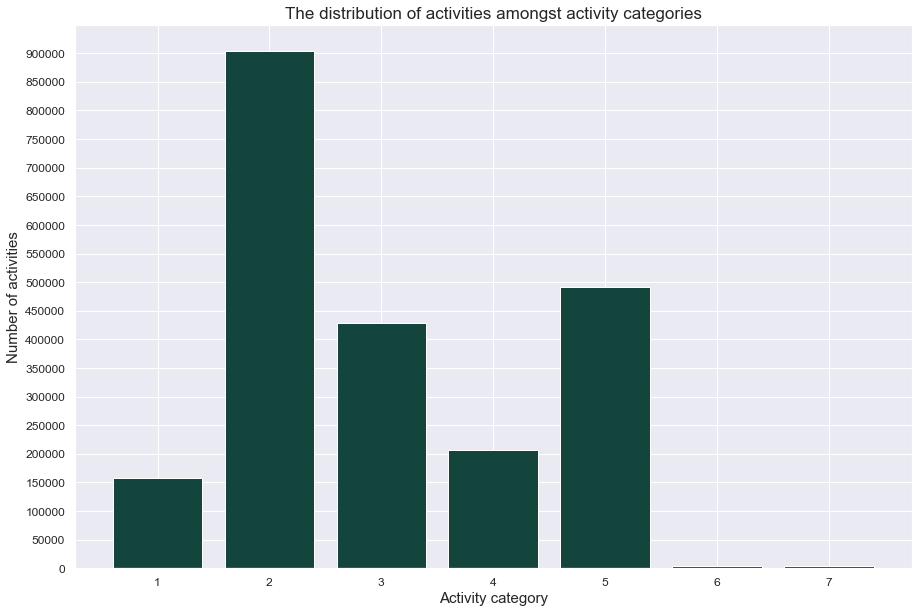

In [49]:
plt.bar(acts['activity_category'], acts['count'], color = '#14453D')
plt.yticks(list(range(0,905000,50000)))
plt.xlabel('Activity category')
plt.ylabel('Number of activities')
plt.title('The distribution of activities amongst activity categories')

Activity category type 2 is the most frequent one, while types 6 and 7 - the least frequent ones.

### 3.2. Exploring `people_df`

In [50]:
list(people_df.columns)

['people_id',
 'char_1',
 'group_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'char_11',
 'char_12',
 'char_13',
 'char_14',
 'char_15',
 'char_16',
 'char_17',
 'char_18',
 'char_19',
 'char_20',
 'char_21',
 'char_22',
 'char_23',
 'char_24',
 'char_25',
 'char_26',
 'char_27',
 'char_28',
 'char_29',
 'char_30',
 'char_31',
 'char_32',
 'char_33',
 'char_34',
 'char_35',
 'char_36',
 'char_37',
 'char_38',
 'month',
 'year',
 'weekend_flg']

In [51]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


In [52]:
len(list(people_df['group_1'].unique()))

34224

#### 3.2.1. chars

In [53]:
chars_people = list(people_df.filter(regex= 'char_', axis=1).columns)

In [54]:
chars_peps_unique=defaultdict(int)

In [55]:
for char in chars_people:
    chars_peps_unique[char]= len((list(people_df[char].unique())))

In [56]:
# char_10-char_37 only two categories - significantly different than in the activity df
chars_peps_unique

defaultdict(int,
            {'char_1': 2,
             'char_2': 3,
             'char_3': 43,
             'char_4': 25,
             'char_5': 9,
             'char_6': 7,
             'char_7': 25,
             'char_8': 8,
             'char_9': 9,
             'char_10': 2,
             'char_11': 2,
             'char_12': 2,
             'char_13': 2,
             'char_14': 2,
             'char_15': 2,
             'char_16': 2,
             'char_17': 2,
             'char_18': 2,
             'char_19': 2,
             'char_20': 2,
             'char_21': 2,
             'char_22': 2,
             'char_23': 2,
             'char_24': 2,
             'char_25': 2,
             'char_26': 2,
             'char_27': 2,
             'char_28': 2,
             'char_29': 2,
             'char_30': 2,
             'char_31': 2,
             'char_32': 2,
             'char_33': 2,
             'char_34': 2,
             'char_35': 2,
             'char_36': 2,
             'cha

It turns out that `people_df` contains much more characteristics with different numbers of categories. `char_1` and`char_10`-`char_37` only have two categories which makes them in fact booleans. The number of categories in other characteristics varies from 3 to 43.

`char_38` is a continuous numerical variable.

Text(0, 0.5, 'Number of categories')

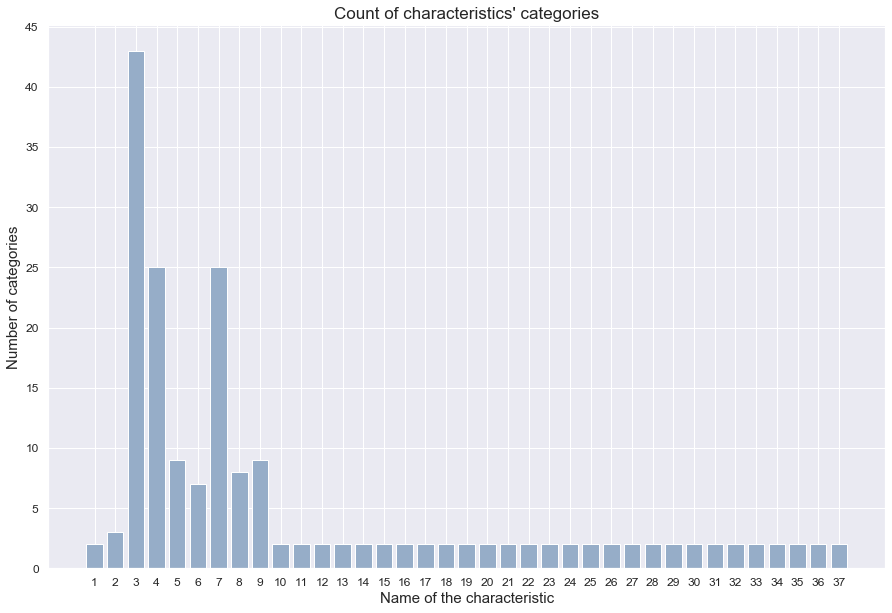

In [57]:
plt.bar(range(1, len(chars_peps_unique)), list(chars_peps_unique.values())[:-1], align='center', color = '#96ADC8')
plt.title("Count of characteristics' categories")
plt.xticks(ticks = list(range(1,38,1)))
plt.yticks(ticks = list(range(0,50,5)))
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')

#### 3.2.2. `group_1`

`group_1` is a categorical variable with no specified meaning

In [58]:
people_df.head(2)

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0


In [59]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).head(2)

,index,group_1
0,17304,77314
1,667,1538


In [60]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).tail(2)

,index,group_1
20608,14230,1
34223,2049,1


In [61]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).shape

(34224, 2)

**34224 different categories**, with the lowest count=1 and the highest count=77314

### Merging data 

Data is being merged at this point to enable a different level of data exploration.

In [62]:
# new pandas 1.0 feature - convert_dtypes(), to handle missing values
red_hat = pd.merge(people_df, train_activity_df, how = 'left', on = 'people_id', suffixes = ('_pep', '_act')).convert_dtypes()

Each row represents an acitivity of a specific person (merged by `people_id`).

`Test_activity_df` will not be used in the project as it is the dataset for competition sumbission and it does not contain information about the target.

In [63]:
red_hat.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2,"(2, 1734928)"
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 2434093)"
2,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 3404049)"
3,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2,"(2, 3651215)"
4,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2,"(2, 4109017)"


In [64]:
#deleting records where outcome or activity_id are NaNs, because they are useless in case of modeling
red_hat = red_hat[(pd.isna(red_hat['activity_id'])== False) & (pd.isna(red_hat['outcome'])== False)]

In [65]:
train_set, test_set = train_test_split(red_hat, test_size = 0.22, random_state = 42, stratify = red_hat['outcome'])

In [66]:
print(train_set.shape)
print(test_set.shape)

(1713886, 61)
(483405, 61)


In [67]:
del people_df
del train_activity_df
del test_activity_df

### 3.3. Exploring `train_set`

#### 3.3.1. Chars

All characteristics are categorical, except `char_38`.

In [68]:
def plot_chars(dataset):
    """
    Input:
    - dataframe with characteristics (either train or test set)
    
    Output:
    -plots for each characterstic
    """
    
    cols_to_plot = list(dataset.filter(regex= 'char_', axis=1).columns)
    
    plt.figure(figsize=(20, 100))

    ax1=plt.subplot(2, 2, 1)

    for i, col in enumerate(cols_to_plot):
        plt.subplot(len(cols_to_plot)/2, 2, i+1, sharey=ax1)
        plt.subplots_adjust(hspace=0.5, wspace = 0.5)
        plt.hist(dataset[col], bins=50, color = '#28AFB0')
        plt.yticks(ticks = list(range(0, 2250000, 250000)), labels = ['0','0.25 mln','0.5 mln', '0.75 mln','1 mln', '1.25 mln', '1.5 mln','1.75 mln','2 mln'])
        plt.title(f"Distribution of categories for {col}")
        plt.xlabel("Category")
        plt.ylabel('Count')

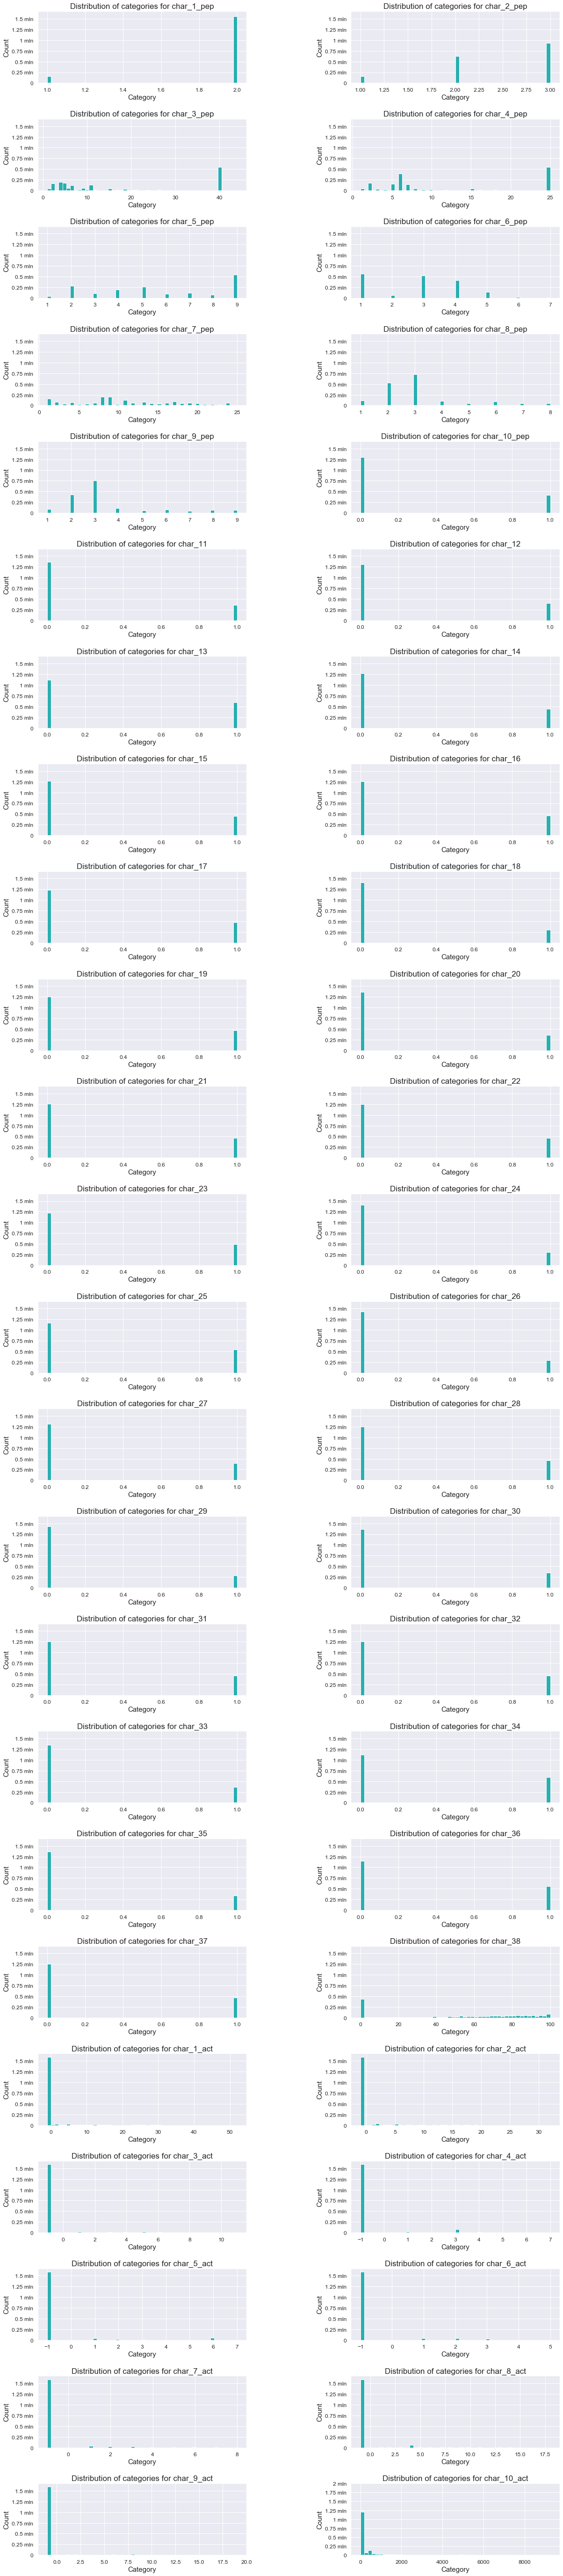

In [69]:
plot_chars(train_set)

**`char_38`**

Text(0, 0.5, 'Probability')

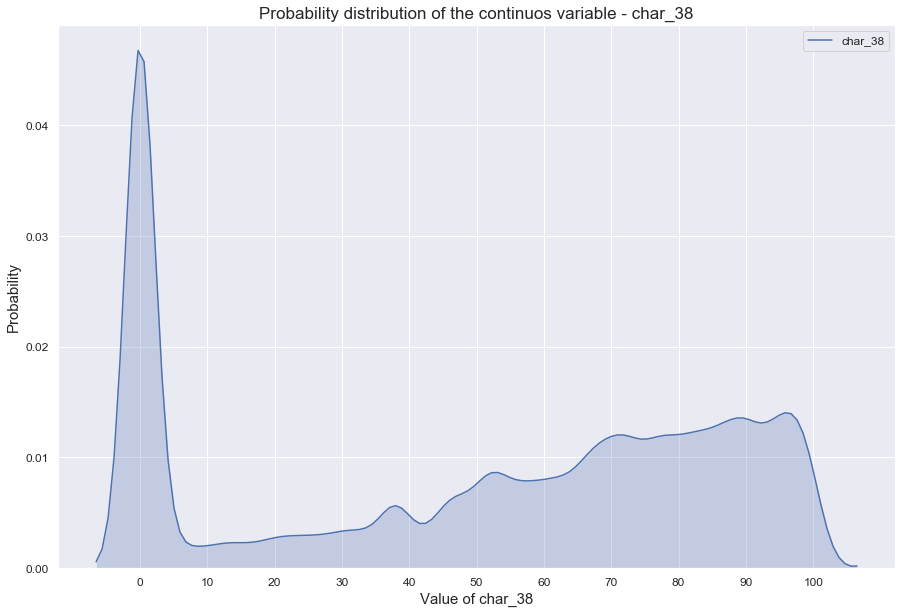

In [70]:
sns.kdeplot(train_set['char_38'], shade=True)
plt.xticks(ticks= list(range(0,102,10)))
plt.title("Probability distribution of the continuos variable - char_38")
plt.xlabel("Value of char_38")
plt.ylabel("Probability")

Text(0, 0.5, 'Number of activities')

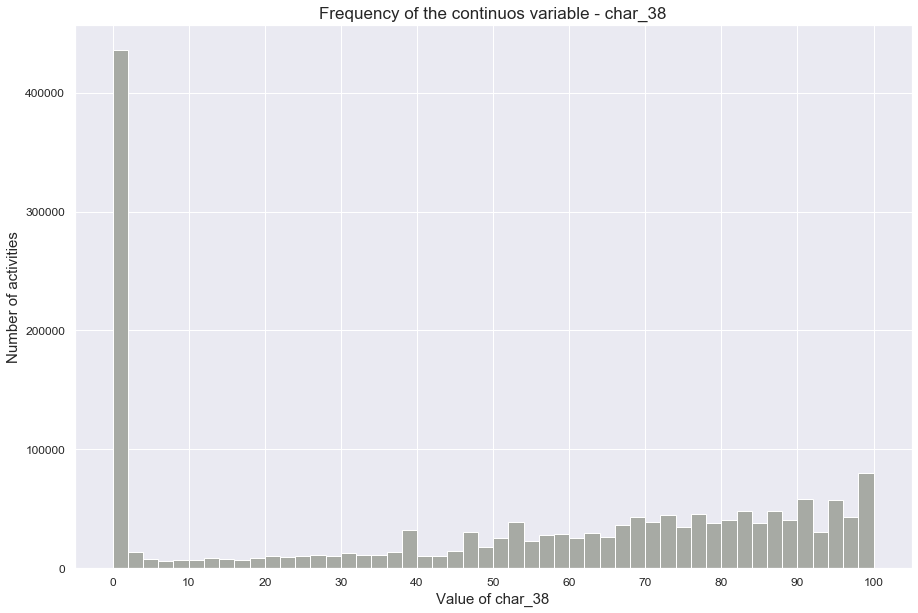

In [71]:
plt.hist(train_set['char_38'], bins=50, color = '#A7AAA4')
plt.xticks(ticks= list(range(0,102,10)))
plt.title("Frequency of the continuos variable - char_38")
plt.xlabel("Value of char_38")
plt.ylabel("Number of activities")

Values of `char_38` for the vast number of activities **are below 5**.

It would be interesting to explore whether there is a significant difference between the distribution of outcomes in case of activities with `char_38` < 5 and `char_38` >= 5.

In [72]:
train_set.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
2116731,79423,2,17304,2,40,25,9,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2022,0,3769922,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,128,0,12,2022,0,2,"(2, 3769922)"
1378585,323246,2,17304,2,4,6,4,1,7,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2022,0,2255070,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,450,0,11,2022,1,2,"(2, 2255070)"
1594600,361248,2,2795,3,7,14,7,3,9,2,2,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1,0,95,9,2022,0,1102570,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,817,1,10,2022,0,2,"(2, 1102570)"
1326429,313960,2,17304,2,40,25,9,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,5,2021,1,4143394,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,2023,1,2,"(2, 4143394)"
2057296,69292,2,17304,2,40,25,9,3,9,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2022,0,3554173,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,248,0,9,2022,0,2,"(2, 3554173)"


In [73]:
below5 = train_set[train_set['char_38']<5].groupby(by = 'outcome')['activity_index'].count().reset_index()

In [74]:
above5 = train_set[train_set['char_38']>=5].groupby(by = 'outcome')['activity_index'].count().reset_index()

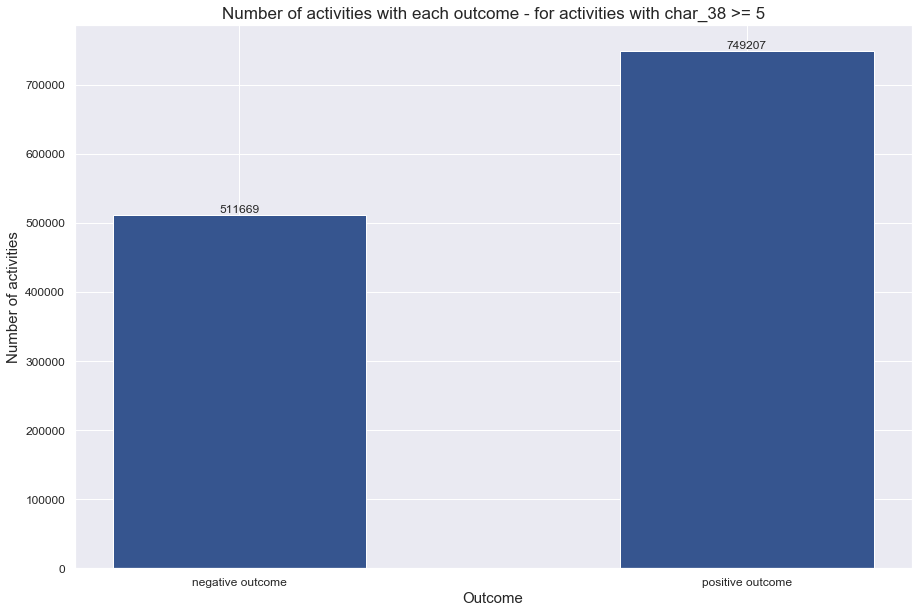

In [75]:
b = plt.bar(above5['outcome'], above5['activity_index'], color = '#36558F' , width = 0.5)
plt.xlabel('Outcome')
plt.ylabel('Number of activities')
plt.xticks(ticks = [0,1], labels = ['negative outcome', 'positive outcome'])
plt.title('Number of activities with each outcome - for activities with char_38 >= 5')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

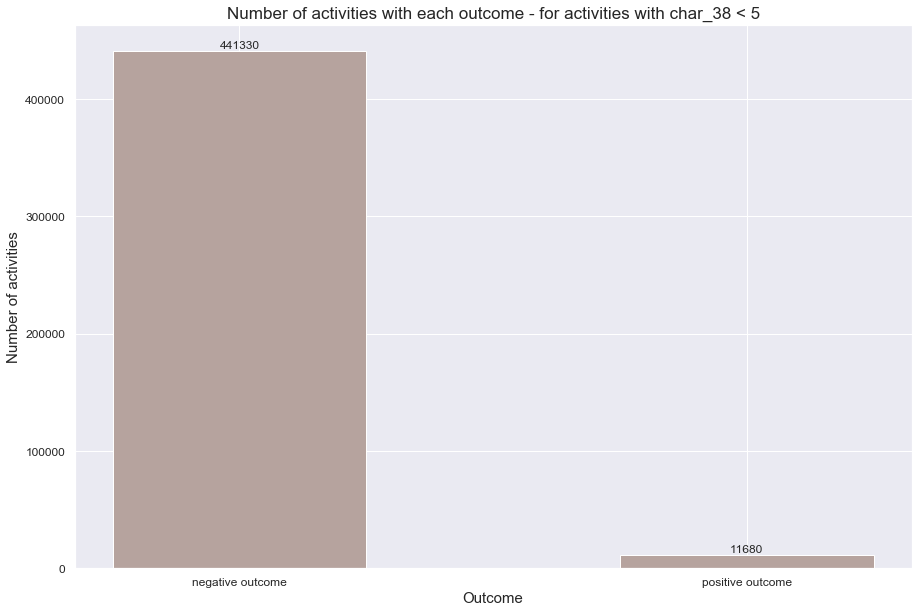

In [76]:
b = plt.bar(below5['outcome'], below5['activity_index'], color = '#B6A39E' , width = 0.5)
plt.xlabel('Outcome')
plt.ylabel('Number of activities')
plt.xticks(ticks = [0,1], labels = ['negative outcome', 'positive outcome'])
plt.title('Number of activities with each outcome - for activities with char_38 < 5')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

The proportion of activities with positive outcome is significantly higher when `char_38` >= 5. The association between `char_38` and the target will be explored further on.

#### 3.3.2. Looking on duplicates

**Full duplicates**

In [77]:
train_set.shape

(1713886, 61)

In [78]:
train_set.drop_duplicates(inplace=True)

/home/joannal/Documents/python_projects/python37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
train_set.shape

(1713886, 61)

No full duplicates found

**Duplicates on `activity_id`**

In [80]:
activities_cnt = pd.DataFrame(train_set['activity_id'].value_counts().reset_index()).rename(columns={'index':'activity_id', 'activity_id':'act_cnt'})

In [81]:
activities_cnt[activities_cnt['act_cnt']>1].shape[0]

41630

In [82]:
acts_check = list(activities_cnt['activity_id'])

68174 duplicates on `activity_id`. Why?

In [83]:
#checking out the duplicates in the train_set df
train_set[train_set['activity_id'].isin(list(activities_cnt['activity_id'][activities_cnt['act_cnt']>1]))].sort_values(by='activity_id').head(15)

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
130805,114719,2,17304,2,5,6,3,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2021,0,12,1,5,2,8,3,5,3,3,9,18,-1,0,4,2023,0,1,"(1, 12)"
1145072,291497,2,17304,2,19,2,5,3,8,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,1,2021,1,12,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,5,2023,0,2,"(2, 12)"
588977,19606,1,283,1,1,1,1,1,1,7,7,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,90,10,2021,1,16,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,10,2022,0,2,"(2, 16)"
604323,198785,2,17304,2,2,6,2,4,13,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2023,0,16,1,12,1,6,3,2,2,3,4,6,-1,0,8,2023,0,1,"(1, 16)"
1377158,323025,2,17304,2,40,25,9,1,7,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2022,0,21,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,4404,0,9,2022,0,2,"(2, 21)"
612458,20012,2,17304,2,40,25,9,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,11,2022,0,21,1,5,2,3,3,5,2,2,4,3,-1,0,3,2023,1,1,"(1, 21)"
698487,215407,2,46797,3,4,6,4,3,11,2,2,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,89,4,2023,1,36,1,1,6,1,1,1,1,1,3,1,-1,0,4,2023,1,1,"(1, 36)"
1399318,326933,2,6479,3,40,25,9,5,22,2,2,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,97,3,2022,0,36,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 36)"
1750816,377952,2,18432,3,15,6,6,3,8,5,5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,84,10,2022,0,43,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,1758,1,10,2022,0,2,"(2, 43)"
1032680,271858,2,38927,3,4,6,4,4,17,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,57,10,2022,0,43,1,12,1,6,5,6,3,4,7,4,-1,0,10,2022,0,1,"(1, 43)"


They are connected to different people, different characteristics, different activity categories and activity prefix.

**Duplicates on `activity_index`**

In [84]:
act_ind = pd.DataFrame(train_set['activity_index'].value_counts().reset_index()).rename(columns={'index':'activity_index','activity_index':'count'})

In [85]:
print(f"{act_ind[act_ind['count']>1].shape[0]} duplicates on activity_id with prefix")

0 duplicates on activity_id with prefix


The **activity id combined with the prefix** is a unique identificator and will be used as an index after data visualisation.

#### 3.3.3. Changes in activities over time

**Yearly**

In [86]:
yearly_pep = pd.DataFrame(train_set.groupby(by = ['year_pep', 'month_pep'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_pep'})

In [87]:
yearly_act = pd.DataFrame(train_set.groupby(by = ['year_act', 'month_act'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_act'})

In [88]:
yearly = pd.merge(yearly_pep, yearly_act, left_on = ['year_pep', 'month_pep'], right_on = ['year_act','month_act'], how = 'left').drop(columns=['year_act', 'month_act'], axis =1)

In [89]:
yearly

,year_pep,month_pep,activities_pep,activities_act
0,2020,5,13063,nan
1,2020,6,21078,nan
2,2020,7,15875,nan
3,2020,8,14634,nan
4,2020,9,11558,nan
5,2020,10,36679,nan
6,2020,11,22910,nan
7,2020,12,19488,nan
8,2021,1,18814,nan
9,2021,2,55746,nan


The dates are probably encoded as they contain future dates.

There are no activities tracked in the activity df **before July 2022**.

In [90]:
yearly['date'] = yearly.apply(lambda x: datetime.datetime.strptime(str(int(x['year_pep'])) + "," + str(int(x['month_pep'])) + ",1", '%Y,%m,%d' ), axis=1)

Text(0.5, 1.0, 'Number of activities over time')

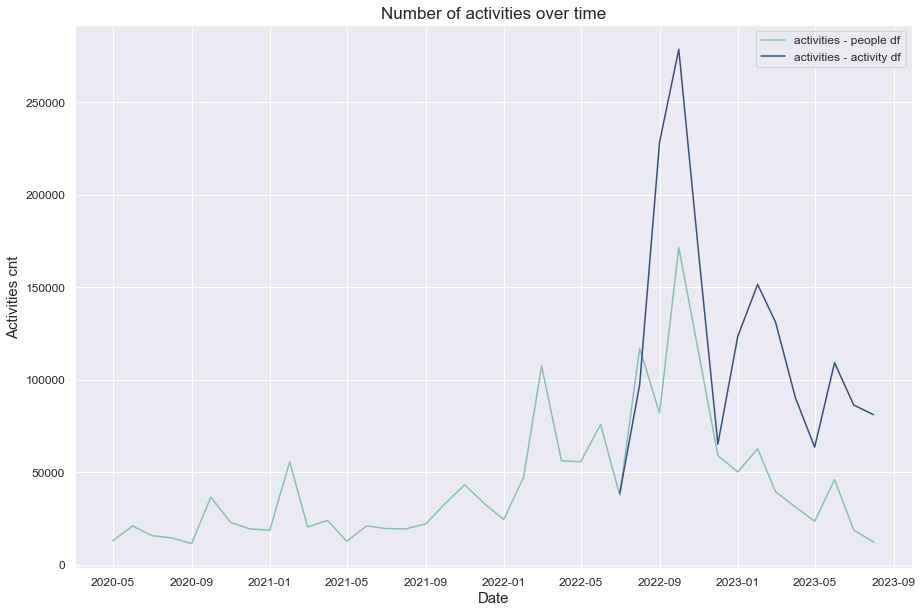

In [91]:
p1, = plt.plot(yearly['date'], yearly['activities_pep'], color = '#8BBEB2')
p2, = plt.plot(yearly['date'], yearly['activities_act'], color = '#384E77')
plt.legend([p1, p2], ["activities - people df", "activities - activity df"])
plt.xlabel("Date")
plt.ylabel("Activities cnt")
plt.title("Number of activities over time")

We can observe a **significant increase** in the number of activities (people df) in **October/November and February** each year since 2020. There are also slight **increases in June**. The number of activities was increasing till the late 2022 and then it started to diminish.

In case of activities in the activity df three peaks are noticable - in October, February and June 2023. Those peaks correspond to peaks of activities from the people df. However, the number of activities in the activity df is significantly higher in this period.

**Yearly vs target**

In [92]:
yearly_pep_outcome = pd.DataFrame(train_set.groupby(by = ['year_pep', 'month_pep','outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_pep'})

In [93]:
yearly_act_outcome = pd.DataFrame(train_set.groupby(by = ['year_act', 'month_act','outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_act'})

In [94]:
yearly_pep_outcome['date'] = yearly_pep_outcome.apply(lambda x: datetime.datetime.strptime(str(int(x['year_pep'])) + "," + str(int(x['month_pep'])) + ",1", '%Y,%m,%d' ), axis=1)
yearly_act_outcome['date'] = yearly_act_outcome.apply(lambda x: datetime.datetime.strptime(str(int(x['year_act'])) + "," + str(int(x['month_act'])) + ",1", '%Y,%m,%d' ), axis=1)

Text(0.5, 1.0, 'Number of activities with different outcome over time - people df')

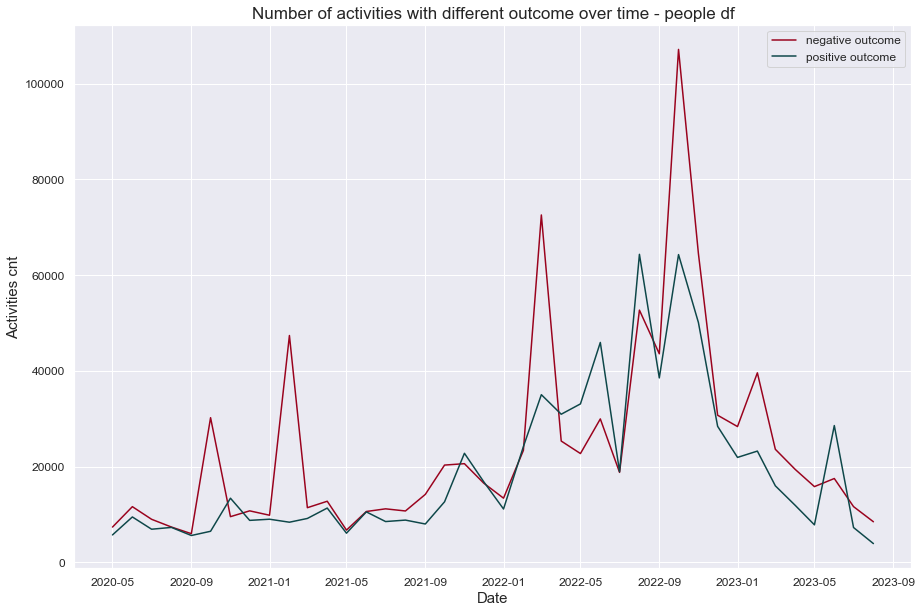

In [95]:
p1, = plt.plot(yearly_pep_outcome['date'][yearly_pep_outcome['outcome']==0], yearly_pep_outcome['activities_pep'][yearly_pep_outcome['outcome']==0], color = '#9A031E')
p2, = plt.plot(yearly_pep_outcome['date'][yearly_pep_outcome['outcome']==1], yearly_pep_outcome['activities_pep'][yearly_pep_outcome['outcome']==1], color = '#0E4749')
plt.legend([p1, p2], ["negative outcome", "positive outcome"])
plt.xlabel("Date")
plt.ylabel("Activities cnt")
plt.title("Number of activities with different outcome over time - people df")

The distribution of activities with both outcomes are similar. Most of the **peaks are overlapping**.

Text(0.5, 1.0, 'Number of activities with different outcome over time - activity df')

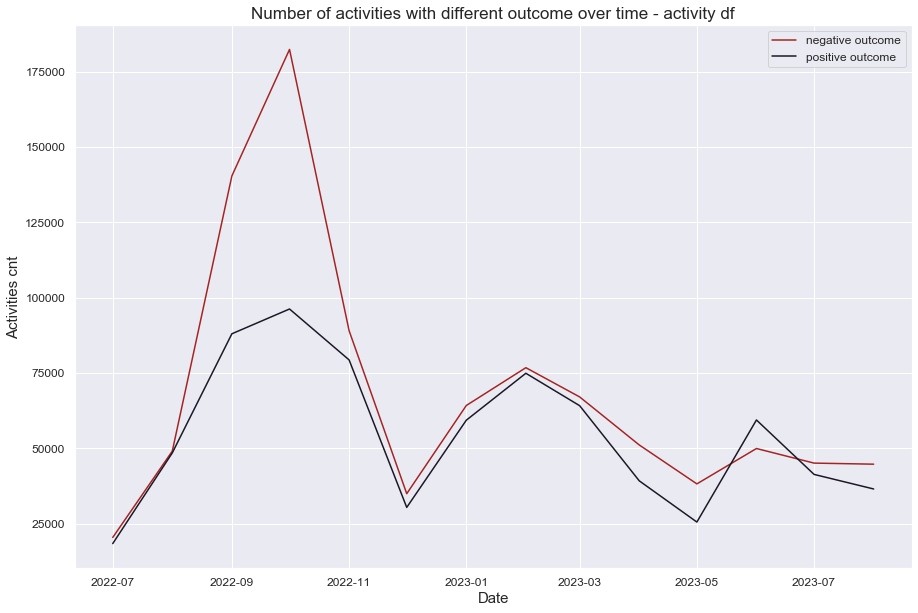

In [96]:
p1, = plt.plot(yearly_act_outcome['date'][yearly_act_outcome['outcome']==0], yearly_act_outcome['activities_act'][yearly_act_outcome['outcome']==0], color = '#A52422')
p2, = plt.plot(yearly_act_outcome['date'][yearly_act_outcome['outcome']==1], yearly_act_outcome['activities_act'][yearly_act_outcome['outcome']==1], color = '#1B1725')
plt.legend([p1, p2], ["negative outcome", "positive outcome"])
plt.xlabel("Date")
plt.ylabel("Activities cnt")
plt.title("Number of activities with different outcome over time - activity df")

As in the case of people df, peaks of activities with different outcomes are overlapping. However, **in October the difference between peaks is the most noticeable**.

**Monthly - average**

In [97]:
dates_act = pd.DataFrame(train_set.groupby(by=["year_act", "month_act"])['activity_index'].count().reset_index())
months_act = pd.DataFrame(dates_act['month_act'].value_counts().reset_index()).rename(columns={'index':'month_act', 'month_act':'num_of_occurences_ACT'})
month_act_acts = pd.DataFrame(train_set[['month_act','activity_index']].groupby(by = 'month_act')['activity_index'].count().reset_index()).rename(columns={'activity_index':'act_cnt_ACT'})

In [98]:
months = pd.merge(months_act, month_act_acts, on = 'month_act')

In [99]:
months['avg_acts_ACT'] = months['act_cnt_ACT']/ months['num_of_occurences_ACT']

In [100]:
dates_pep = pd.DataFrame(train_set.groupby(by=["year_act", "month_pep"])['activity_index'].count().reset_index())
months_pep = pd.DataFrame(dates_pep['month_pep'].value_counts().reset_index()).rename(columns={'index':'month_pep', 'month_pep':'num_of_occurences_PEP'})
month_pep_acts = pd.DataFrame(train_set[['month_pep','activity_index']].groupby(by = 'month_pep')['activity_index'].count().reset_index()).rename(columns={'activity_index':'act_cnt_PEP'})

In [101]:
months_p = pd.merge(months_pep, month_pep_acts, on = 'month_pep')

In [102]:
months_p['avg_acts_PEP'] = months_p['act_cnt_PEP']/ months_p['num_of_occurences_PEP']

In [103]:
months = pd.merge(months, months_p, left_on = 'month_act', right_on = 'month_pep')

In [104]:
months = months[['month_act', 'act_cnt_ACT', 'avg_acts_ACT', 'act_cnt_PEP', 'avg_acts_PEP']]

In [105]:
months = months.sort_values(by = 'month_act').reset_index(drop=True)

Text(0.5, 1.0, 'Average number of activities in each month')

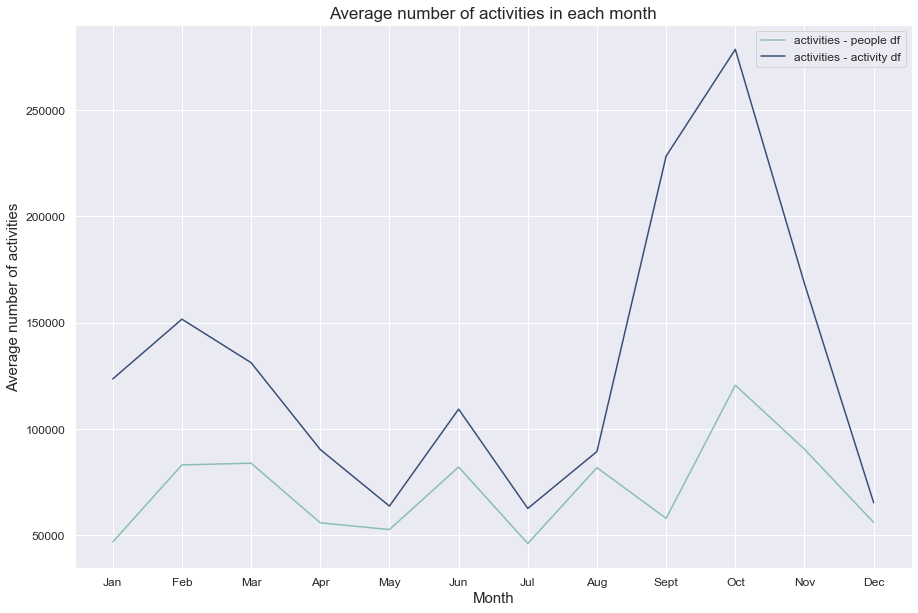

In [106]:
p1, = plt.plot(months['month_act'], months['avg_acts_PEP'],color = '#8BBEB2')
p2, = plt.plot(months['month_act'], months['avg_acts_ACT'], color = '#384E77')
plt.xticks(ticks = list(range(1,13)), labels = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sept', 'Oct','Nov', 'Dec'])
plt.legend([p1, p2], ["activities - people df", "activities - activity df"])
plt.xlabel("Month")
plt.ylabel("Average number of activities")
plt.title("Average number of activities in each month")

We see that the trend is similar for both dataframes, with the biggest **difference in September**. The plot also proves the **peaks in June, October and February**.

But how does the coverage of activities look like between those two sources of activities?

**Monthly - count**

In [107]:
#the same as above, but a stacked plot with the intersection, pep and act unique
inter_act = {}

In [108]:
for x in range(1,13):
    inter_act[x] = list(train_set['activity_index'][(train_set['month_act']==x) & (train_set['month_pep']==x) ].unique())

In [109]:
months['intersection_activities'] = [len(inter_act[x]) for x in range(1,13)]

In [110]:
months['unique_act'] = months['act_cnt_ACT'] - months['intersection_activities'] 
months['unique_pep'] = months['avg_acts_PEP'] - months['intersection_activities'] 

Text(0.5, 1.0, 'Number of activities in each month in the context of the source of activity')

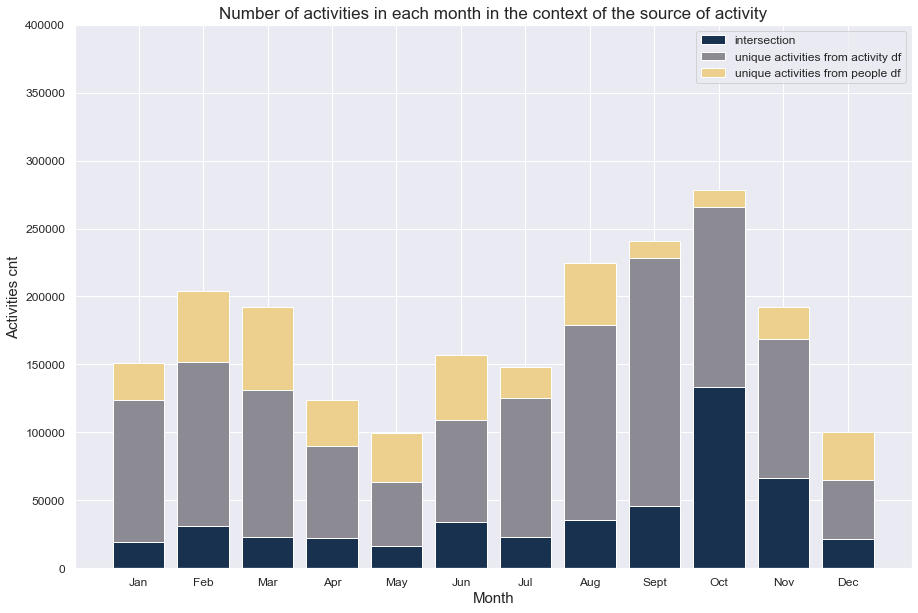

In [111]:
bottom = np.array(months['intersection_activities'] + months['unique_act'])

b1 = plt.bar(months['month_act'], months['intersection_activities'], color = '#18314F')
b2 = plt.bar(months['month_act'], months['unique_act'], color = '#8C8A93', bottom = months['intersection_activities'])
b3 = plt.bar(months['month_act'], months['unique_pep'], color = '#EDCF8E', bottom = bottom)
plt.xticks(ticks = list(range(1,13)), labels = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sept', 'Oct','Nov', 'Dec'])
plt.yticks(ticks = list(range(0,400001,50000)))
plt.legend([b1, b2, b3], ["intersection", "unique activities from activity df", "unique activities from people df"])
plt.xlabel("Month")
plt.ylabel("Activities cnt")
plt.title("Number of activities in each month in the context of the source of activity")

The intersection between two groups of activities is rather small, excluding October activities.

**Weekends and weekdays**

In [112]:
week_act = pd.DataFrame(train_set.groupby(by = 'weekend_flg_act')['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_act'})
week_pep = pd.DataFrame(train_set.groupby(by = 'weekend_flg_pep')['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_pep'})

In [113]:
week = pd.merge(week_act, week_pep, left_on = 'weekend_flg_act', right_on = 'weekend_flg_pep').drop('weekend_flg_pep', axis=1)

Text(0.5, 1.0, 'Number of activities depending on the part of the week')

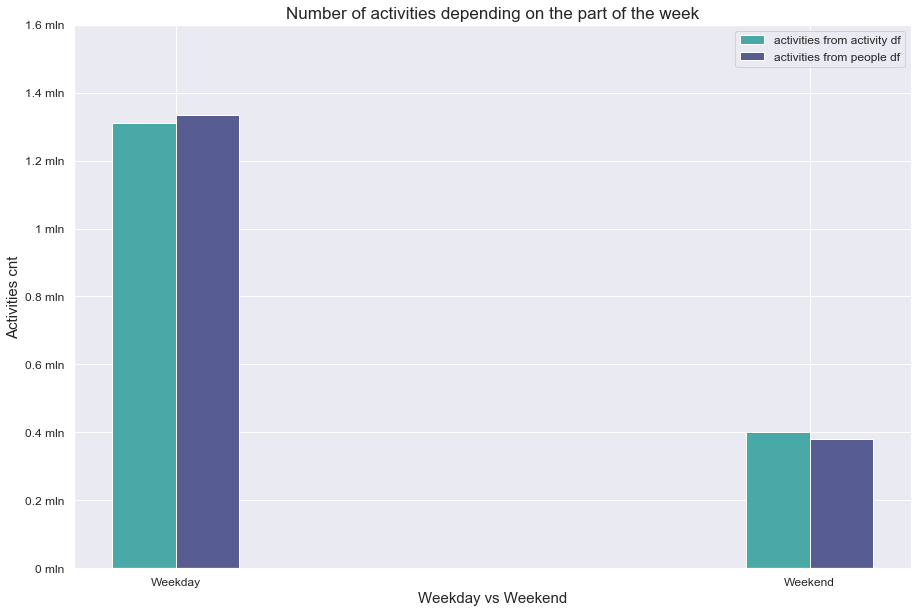

In [114]:
b1 = plt.bar(week['weekend_flg_act']-0.1, week['acts_act'], width=0.1, color='#48A9A6', align='edge')
b2 = plt.bar(week['weekend_flg_act']+0.05, week['acts_pep'], width=0.1, color='#575D90', align='center')
plt.xticks(ticks = list(range(0,2)), labels = ['Weekday','Weekend'])
plt.yticks(ticks = list(range(0,1800000, 200000)), labels = ['0 mln', '0.2 mln', '0.4 mln', '0.6 mln', '0.8 mln', '1 mln', '1.2 mln', '1.4 mln', '1.6 mln'])
plt.legend([b1, b2], ["activities from activity df","activities from people df"])
plt.xlabel("Weekday vs Weekend")
plt.ylabel("Activities cnt")
plt.title("Number of activities depending on the part of the week")

The majority of activities (from both dataframes) happen **on weekdays**.

**Weekend vs. target**

In [115]:
week_act = pd.DataFrame(train_set.groupby(by = ['weekend_flg_act', 'outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_act'})

In [116]:
week_pep = pd.DataFrame(train_set.groupby(by = ['weekend_flg_pep', 'outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_pep'})

Text(0.5, 1.0, 'Number of activities depending on the part of the week - activities df')

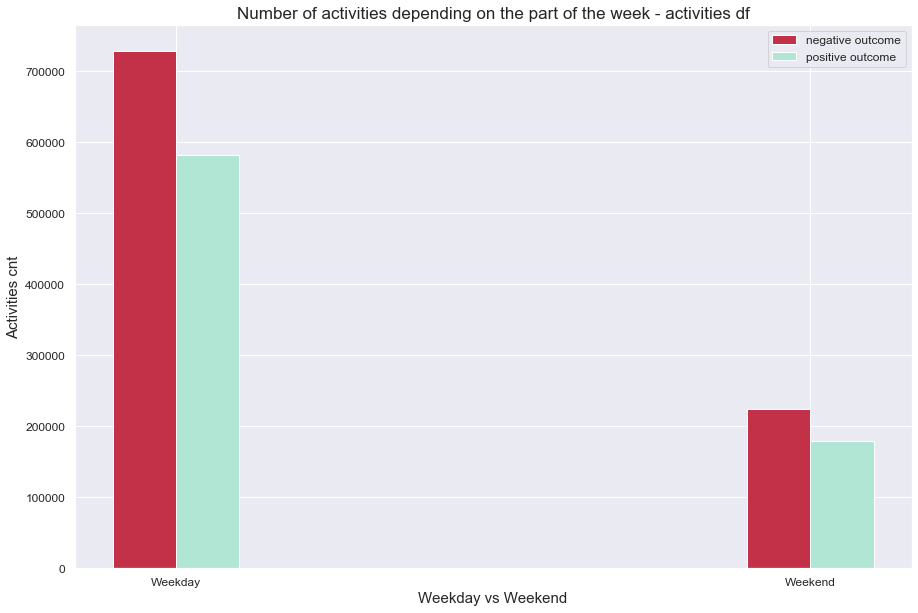

In [117]:
b1 = plt.bar(week_act['weekend_flg_act'][week_act['outcome']==0].reset_index(drop=True)-0.1, week_act['acts_act'][week_act['outcome']==0].reset_index(drop=True), width=0.1, color='#C33149', align='edge')
b2 = plt.bar(week_act['weekend_flg_act'][week_act['outcome']==1].reset_index(drop=True)+0.05, week_act['acts_act'][week_act['outcome']==1].reset_index(drop=True), width=0.1, color='#B2E6D4', align='center')
plt.legend([b1, b2], ["negative outcome","positive outcome"])
plt.xticks(ticks = list(range(0,2)), labels = ['Weekday','Weekend'])
plt.xlabel("Weekday vs Weekend")
plt.ylabel("Activities cnt")
plt.title("Number of activities depending on the part of the week - activities df")

Text(0.5, 1.0, 'Number of activities depending on the part of the week - people df')

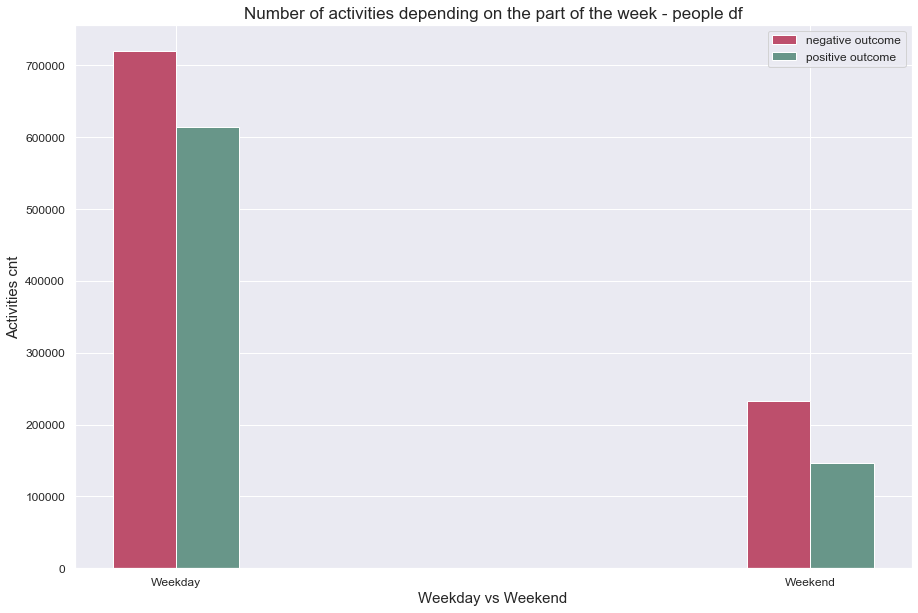

In [118]:
b1 = plt.bar(week_pep['weekend_flg_pep'][week_pep['outcome']==0].reset_index(drop=True)-0.1, week_pep['acts_pep'][week_pep['outcome']==0].reset_index(drop=True), width=0.1, color='#BD4F6C', align='edge')
b2 = plt.bar(week_pep['weekend_flg_pep'][week_pep['outcome']==1].reset_index(drop=True)+0.05, week_pep['acts_pep'][week_pep['outcome']==1].reset_index(drop=True), width=0.1, color='#689689', align='center')
plt.legend([b1, b2], ["negative outcome","positive outcome"])
plt.xticks(ticks = list(range(0,2)), labels = ['Weekday','Weekend'])
plt.xlabel("Weekday vs Weekend")
plt.ylabel("Activities cnt")
plt.title("Number of activities depending on the part of the week - people df")

In [119]:
def find_percentage(df, weekend_col, activity_col):
    week_activ = df.groupby(by= weekend_col)[activity_col].sum().reset_index()
    
    weekdays = week_activ.iloc[0,1]
    weekends = week_activ.iloc[1,1]
    
    weekdays_df = df.iloc[:2,:]
    weekends_df = df.iloc[2:,:]
    
    weekends_df['perc_outcome'] = weekends_df[activity_col]/weekends*100
    weekdays_df['perc_outcome'] = weekdays_df[activity_col]/weekdays*100
    
    return weekdays_df, weekends_df

In [120]:
weekdays_act, weekends_act = find_percentage(week_act, 'weekend_flg_act', 'acts_act')

/home/joannal/Documents/python_projects/python37_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/joannal/Documents/python_projects/python37_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [121]:
weekdays_pep, weekends_pep = find_percentage(week_pep, 'weekend_flg_pep', 'acts_pep')

/home/joannal/Documents/python_projects/python37_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/joannal/Documents/python_projects/python37_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [122]:
weekdays_act

,weekend_flg_act,outcome,acts_act,perc_outcome
0,0,0,729209,55.603
1,0,1,582249,44.397


In [123]:
weekends_act

,weekend_flg_act,outcome,acts_act,perc_outcome
2,1,0,223790,55.610
3,1,1,178638,44.390


In [124]:
weekdays_pep

,weekend_flg_pep,outcome,acts_pep,perc_outcome
0,0,0,720543,53.992
1,0,1,614004,46.008


In [125]:
weekends_pep

,weekend_flg_pep,outcome,acts_pep,perc_outcome
2,1,0,232456,61.279
3,1,1,146883,38.721


In case of both weekends and weekdays **the number of activities with negative outcome is higher** than the number of activities with positive outcome.

In case of activities from the activity df the proportions looks similar for the weekends and weekdays: **56% - negative, 44% - positive**. Those proportions look different for the activities from people df, especially in case of weekends: **61% - negative, 39% - positive**.

#### 3.3.4. Exploring the outcome

In [126]:
outcomes = pd.DataFrame(train_set.groupby(by = ['outcome'])['activity_index'].count().reset_index())

Text(0.5, 1.0, 'Number of activities with each outcome')

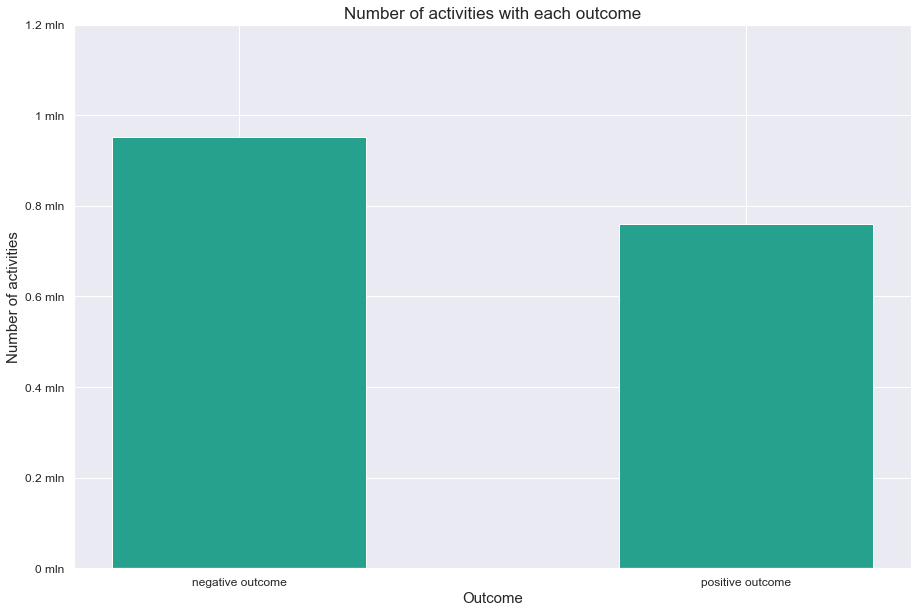

In [127]:
plt.bar(outcomes['outcome'], outcomes['activity_index'], color = '#25A18E', width = 0.5)
plt.xlabel('Outcome')
plt.ylabel('Number of activities')
plt.xticks(ticks = [0,1], labels = ['negative outcome', 'positive outcome'])
plt.yticks(ticks = list(range(0,1300000, 200000)), labels = ['0 mln', '0.2 mln', '0.4 mln', '0.6 mln', '0.8 mln', '1 mln', '1.2 mln', '1.4 mln'])
plt.title('Number of activities with each outcome')

#### 3.3.5. People and activities

**Number of activities per person**

In [128]:
peps_acts = pd.DataFrame(train_set.groupby(by = 'people_id')['activity_index'].count().reset_index())

Text(0.5, 1.0, 'Number of activities per person')

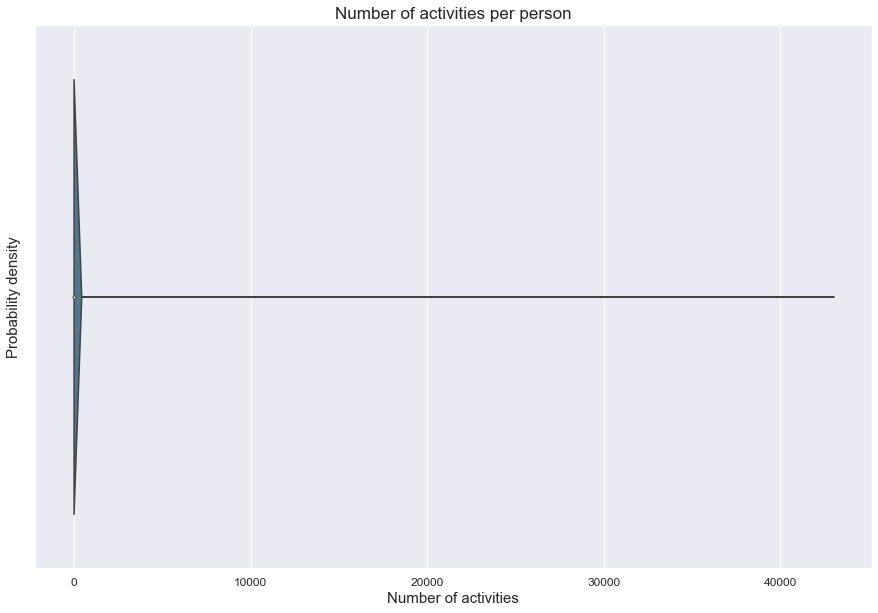

In [129]:
sns.violinplot(peps_acts['activity_index'], color = '#477998')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities per person')

Text(0.5, 1.0, 'Number of activities per person - max 100')

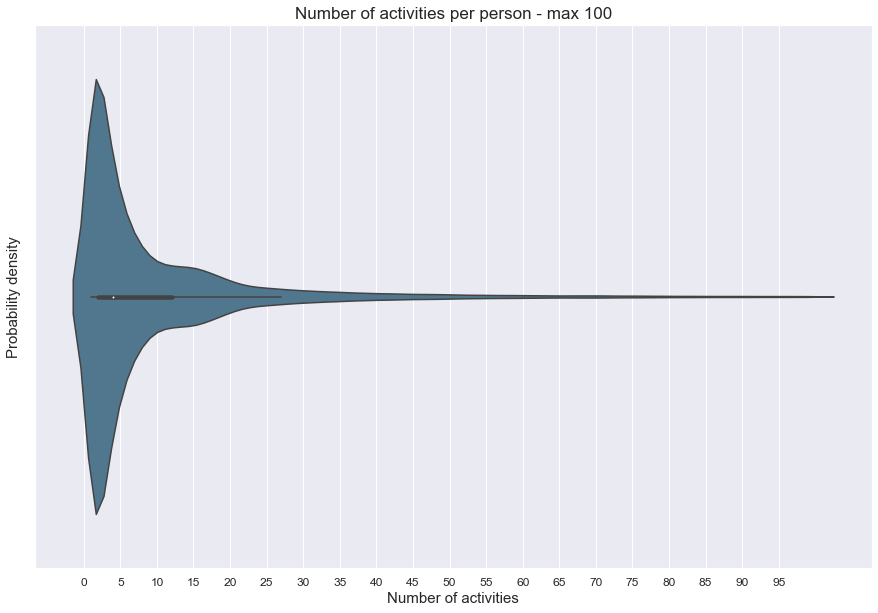

In [130]:
sns.violinplot(peps_acts['activity_index'][peps_acts['activity_index']<=100], color = '#477998')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities per person - max 100')

There is a number of outliers in case of the number of activities per person. The **median oscillates around 5** activities per person, but there are people with **40.000 activities** and more.

**Number of activities per person depending on the outcome**

In [131]:
peps_acts_0 = pd.DataFrame(train_set[train_set['outcome']==0].groupby(by = 'people_id')['activity_index'].count().reset_index())
peps_acts_1 = pd.DataFrame(train_set[train_set['outcome']==1].groupby(by = 'people_id')['activity_index'].count().reset_index())

Text(0.5, 1.0, 'Number of activities with negative outcome per person')

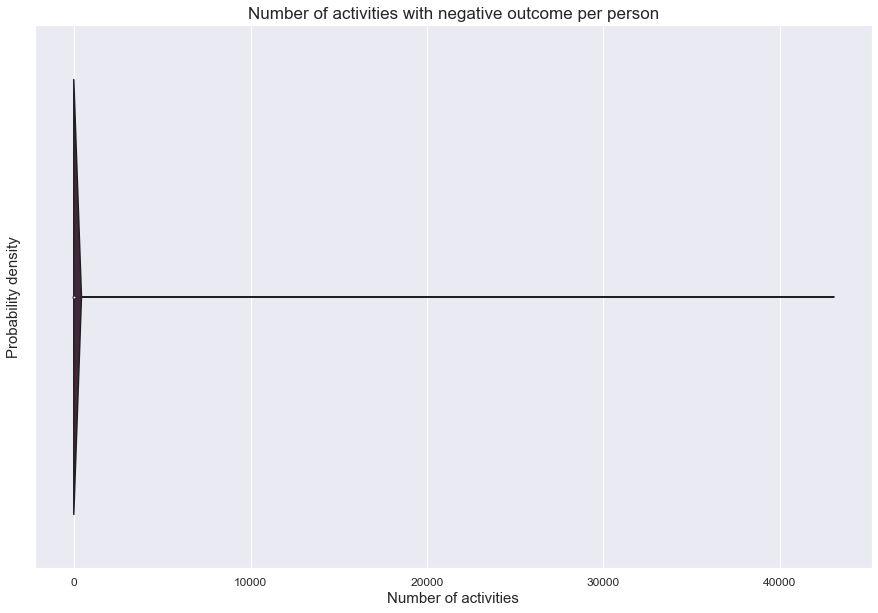

In [132]:
sns.violinplot(peps_acts_0['activity_index'], color = '#48233C')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities with negative outcome per person')

Text(0.5, 1.0, 'Number of activities with negative outcome per person - max 100')

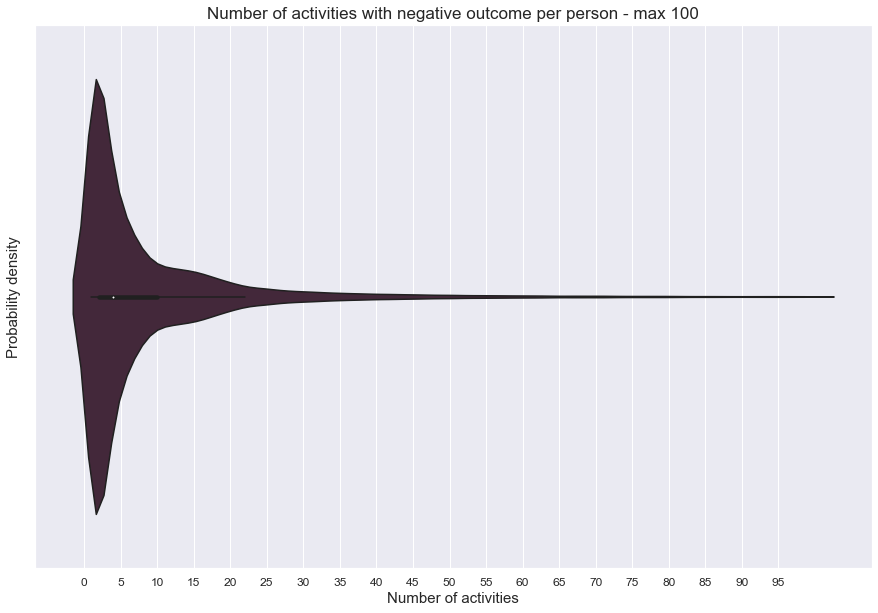

In [133]:
sns.violinplot(peps_acts_0['activity_index'][peps_acts_0['activity_index']<=100], color = '#48233C')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities with negative outcome per person - max 100')

The shape of the distribution for activities with negative outcomes is similar to that of all activities. The median, however, is slightly smaller - **around 4**. The **1.5x interquantile range is smaller** than for all activities.

Text(0.5, 1.0, 'Number of activities with positive outcome per person')

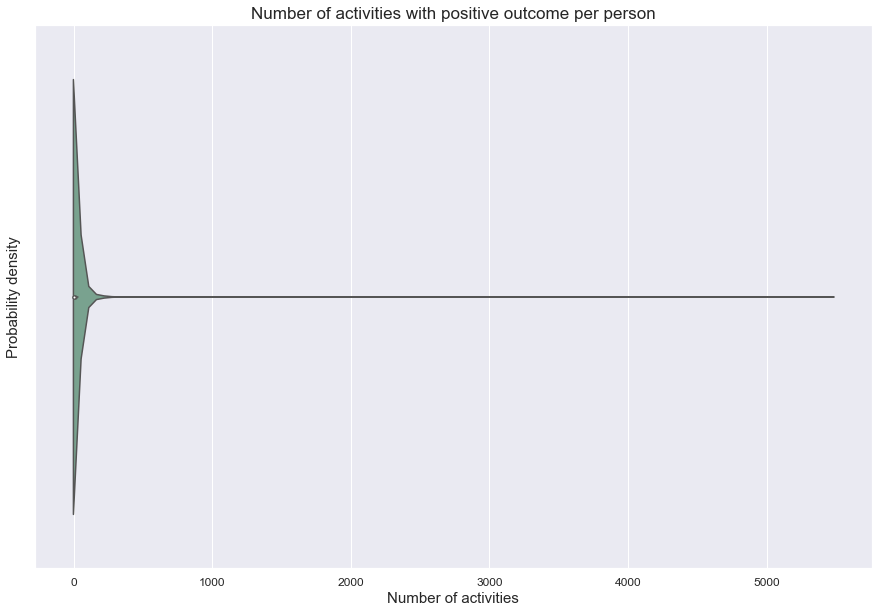

In [134]:
sns.violinplot(peps_acts_1['activity_index'], color = '#72A98F')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities with positive outcome per person')

Text(0.5, 1.0, 'Number of activities with positive outcome per person - max 100')

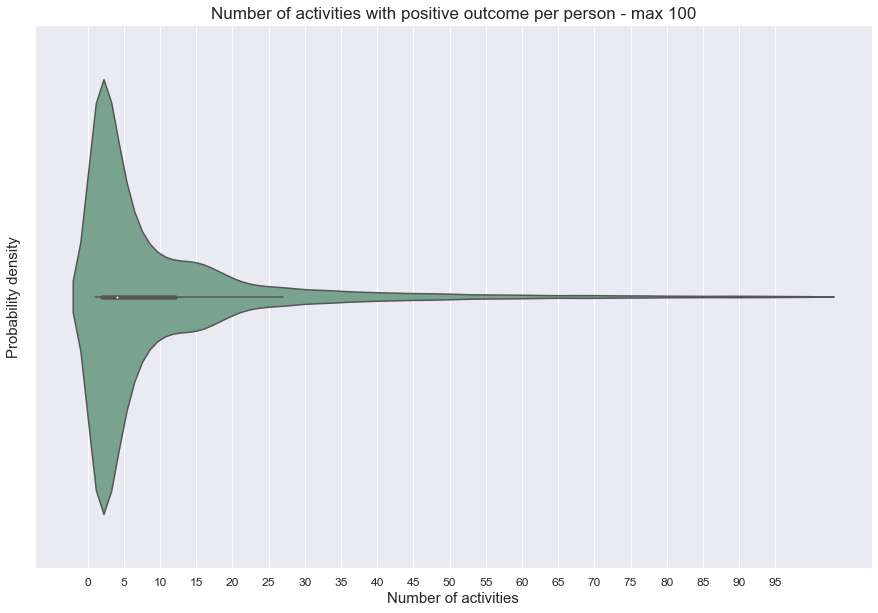

In [135]:
sns.violinplot(peps_acts_1['activity_index'][peps_acts_1['activity_index']<=100], color = '#72A98F')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities with positive outcome per person - max 100')

The shape of the distribution for activities with positive outcomes shows some differences comparing to the previous plots. The **median oscillates around 5**, just as in case of all activities. 

However, there is a noticably higher density **between 15 and 25** activities, which can not be seen in previous plots.

#### 3.3.6. Exploring correlation

Correlation between categorical variables (features and target) will be tested using a number of statistical measures, including **chi-square** and **Cramer's V**. 

In [138]:
train_set = train_set.set_index('activity_index')

In [139]:
index_cols = ['activity_id_prefix', 'activity_id']
cat_cols = ['char_10_act' , 'group_1']
target = ['outcome']
continuous_cols = ['char_38']

In [140]:
#categorical variables to check correlation between them and target
cols_corr = [x for x in list(train_set.columns) if x not in target+continuous_cols]

**Chi-square**

In [141]:
def find_corr_chi2(df, cols_to_check, target, alpha=0.05):
    """ 
    The aim of the function is to find correlation between two categorical variables, using chi-square.
    
    The function takes in:
    - a dataframe with variables and target, 
    - a list of categorical columns, 
    - the name of the column with target (to check the correlation between categorical columns and target), 
    - an alpha parameter (with default=0.5).
    
    The output of the function is a list of variables which are highly correlated to the target.
    """
    
    
    cols_to_drop = []
    
    for col in cols_to_check:

        #chi-square value , p-value, degrees of freedom, expected frequencies
        stat, p, dof, expected = chi2_contingency(pd.crosstab(df[col],df[target]))
        print(f"{col}: significance={alpha}, p={p}")

        if p <= alpha:
            print(f'Target and {col} are associated')
            cols_to_drop.append(col)
        else:
            pass

        
    return cols_to_drop

In [142]:
chi2_cols = find_corr_chi2(train_set, cols_corr, 'outcome')

people_id: significance=0.05, p=0.0
Target and people_id are associated
char_1_pep: significance=0.05, p=0.0
Target and char_1_pep are associated
group_1: significance=0.05, p=0.0
Target and group_1 are associated
char_2_pep: significance=0.05, p=0.0
Target and char_2_pep are associated
char_3_pep: significance=0.05, p=0.0
Target and char_3_pep are associated
char_4_pep: significance=0.05, p=0.0
Target and char_4_pep are associated
char_5_pep: significance=0.05, p=0.0
Target and char_5_pep are associated
char_6_pep: significance=0.05, p=0.0
Target and char_6_pep are associated
char_7_pep: significance=0.05, p=0.0
Target and char_7_pep are associated
char_8_pep: significance=0.05, p=0.0
Target and char_8_pep are associated
char_9_pep: significance=0.05, p=0.0
Target and char_9_pep are associated
char_10_pep: significance=0.05, p=0.0
Target and char_10_pep are associated
char_11: significance=0.05, p=0.0
Target and char_11 are associated
char_12: significance=0.05, p=0.0
Target and char_

In [143]:
print(f"{len(chi2_cols)}/{len(cols_corr)} are associated to the target based on chi-squared")

56/58 are associated to the target based on chi-squared


Chi-square test turned out to classify **53/54 categorical variables as associated with the target**. But the small p-values might be associated with very large sample sizes, as Chi-square is sensitive to sample size.

Therefore, `chi2_cols` won't be dropped from the dataset and a different approach to the correlation between categorical variables will be tested.

**Cramer's V**

In [144]:
def cramers_corrected_stat(cols_to_check, df, target, thresh):
    """ 
    The aim of the function is to calculate the corrected version of Cramer's V to find the level of association between categorical variables.
    
    The function takes in:
    - a dataframe with categorical variables, 
    - a list of categorical variables to check, 
    - the name of the column with target,
    - a threshold for Cramer's V values from which strong association will be assumed.
    
    The result of the function is a list of variables which are strongly associated with the target, according to the Cramer's V values.
    """
    
    cols_to_drop = []
    
    for col in cols_to_check:

        confusion_matrix = pd.crosstab(df[col],df[target])
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r,c = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((c-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        ccorr = c - ((c-1)**2)/(n-1)
        cramers_v = np.sqrt(phi2corr / min( (ccorr-1), (rcorr-1)))
        
        if cramers_v > thresh:
            print(f'Target and {col} are associated: {round(cramers_v,2)}')
            cols_to_drop.append(col)
        else:
            pass
    
    return cols_to_drop

In [145]:
%%latex
$$ \text{The association between variables and target will by analized according to the following guidelines:} $$
$$ V \in[0,0.3] \text{ - weak association} $$
$$ V \in(0.3,0.5] \text{ - medium association} $$
$$ V > 0.5 \text{ - strong association} $$

<IPython.core.display.Latex object>

In [146]:
cramer_cols = cramers_corrected_stat(cols_corr, train_set, 'outcome', 0.5)

Target and people_id are associated: 0.92
Target and group_1 are associated: 0.95
Target and char_2_pep are associated: 0.68


In [147]:
cramer_cols

['people_id', 'group_1', 'char_2_pep']

Columns mentioned in `cramer_cols` will be deleted from the dataset as they are stronly associated with the target.

**Pearson correlation**

Pearson correlation coefficient can be calculated either for continuous variables or for a categorical variable which has a 0/1-coding for the categories. This correlation is called **point-biserial correlation coefficient**.

It will be calculated for the only continuous variable in the dataset - `char_38` and the target.

In [148]:
def point_biserial_correlation(df, contin_cols, target, thresh):
    """
    The aim of the function is to calculate a point biserial correlation coefficient and the associated p-value.
    
    The function takes in:
    - a dataframe with variables for which we want to test correlation
    - a list of continuous variable
    - a binary variable (target)
    - a threshold for correlation coeficient from which strong correlation will be assumed.
    
    The result of the function is a list of variables with high correlation.
    """
    
    cols_to_drop = []
    
    for col in contin_cols:
    
        corr = pointbiserialr(df[col],df[target])[0]
        p = pointbiserialr(df[col],df[target])[1]
    
        if (p<=0.5):
            if (abs(corr)>thresh):
                print(f"{col} is correlated with the target: {round(corr,2)}")
                cols_to_drop.append(col)
            else:
                print(f"{col} with low correlation")
        else:
            print(f"No statistically significant correlation")
    
    return cols_to_drop

In [149]:
%%latex
$$ \text{The point biserial correlation coefficient between variables and target will by analized according to the following guidelines:} $$
$$ \mid P\mid  \in[0,0.3] \text{ - weak association} $$
$$ \mid P\mid \in(0.3,0.5] \text{ - medium association} $$
$$ \mid P\mid > 0.5 \text{ - strong association} $$

<IPython.core.display.Latex object>

In [150]:
point_biserial_cols = point_biserial_correlation(train_set, continuous_cols, 'outcome', 0.5)

char_38 is correlated with the target: 0.68


In [151]:
point_biserial_cols

['char_38']